# Dirichlet wrapper wit OOD detection
The goal of this work is to obtain a method for detecting OOD using the Dirichlet wrapper.

In [1]:
import pandas as pd
import numpy as np
'''NN'''
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Dropout, Input, concatenate, Activation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import Model
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.python.keras.utils import to_categorical
import tensorflow as tf
import tensorflow_probability as tfp

In [2]:
#@title Toy dataset generator Params
num_centers = 3 #@param {type:"slider", min:2, max:10, step:1}
n_samples = 20000 #@param {type:"integer"}
n_features = 2 #@param {type:"integer"}
cluster_std = 3 #@param {type:"slider", min:0, max:4, step:0.1}
num_classes = 3 #@param {type:"slider", min:2, max:10, step:1}
num_mc_samples = 1000 #@param {type:"integer"}



In [3]:
# scatter plot of blobs dataset
from sklearn.datasets.samples_generator import make_blobs
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl

from pandas import DataFrame
# generate 2d classification dataset
X, y = make_blobs(n_samples=n_samples, centers=num_centers, n_features=n_features, cluster_std=cluster_std, random_state=6)
#fake_data = np.random.normal((5,-25), 1, [1000,num_classes])
#X = np.concatenate((X,fake_data))
#y = np.concatenate((y,np.array([0]*fake_data.shape[0])))

/Users/n955171/miniconda3/envs/uncertanty_modeller_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42)
fake_data_test = np.random.normal((20,-20), 1, [1000,n_features])
X_test = np.concatenate((X_test,fake_data_test))
y_test = np.concatenate((y_test,np.array([2]*fake_data_test.shape[0])))
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.4, 
                                                    random_state=42)
fake_data_val = np.random.normal((20,-20), 1, [1000,n_features])
X_val = np.concatenate((X_val,fake_data_val))
y_val = np.concatenate((y_val,np.array([2]*fake_data_val.shape[0])))

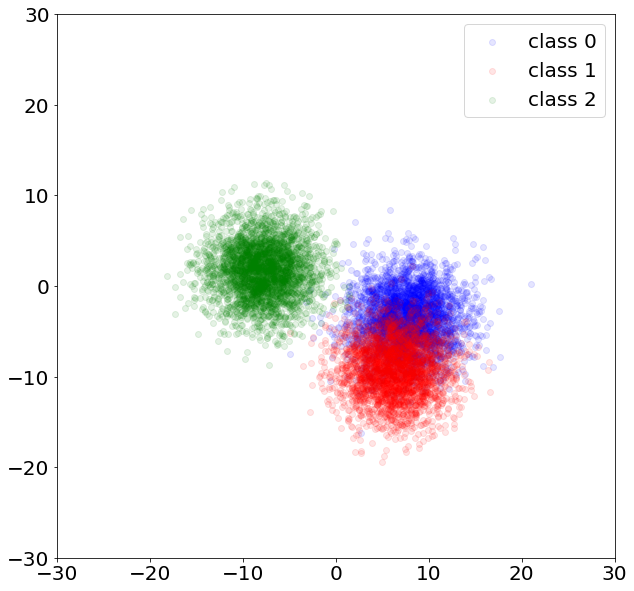

In [6]:
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(10,10))
plt.gca().set_xlim([-30.,30.])
plt.gca().set_ylim([-30.,30.])
plt.scatter(X_train[:,0][y_train==0], X_train[:,1][y_train==0], label='class 0', c='b',  alpha=0.1)
plt.scatter(X_train[:,0][y_train==1], X_train[:,1][y_train==1], label='class 1', c='r',  alpha=0.1)
plt.scatter(X_train[:,0][y_train==2], X_train[:,1][y_train==2], label='class 2', c='g',  alpha=0.1)
plt.legend()

In [7]:
fake_input = Input(shape=(n_features,))
fake_output = Dense(num_classes, activation='softmax')(fake_input)
fake_model = Model(inputs=[fake_input], outputs=fake_output)
fake_model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=Adam(lr=1e-3),
                  metrics=['accuracy'])
fake_es = EarlyStopping(monitor='val_loss', min_delta=0, patience=50, verbose=0, mode='auto', restore_best_weights=True)
fake_training_history = fake_model.fit([X_train],
                                 y_train,
                                 batch_size=64,
                                 epochs=100,
                                 verbose=1,
                                 callbacks=[fake_es],
                                 validation_split=0.1)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 8640 samples, validate on 960 samples
Epoch 1/100
8640/8640 [==============================] - 0s 18us/sample - loss: 17.1498 - acc: 0.0017 - val_loss: 15.4395 - val_acc: 0.0063
Epoch 2/100
8640/8640 [==============================] - 0s 11us/sample - loss: 13.8324 - acc: 0.0016 - val_loss: 12.1285 - val_acc: 0.0052
Epoch 3/100
8640/8640 [==============================] - 0s 11us/sample - loss: 10.5319 - acc: 0.0023 - val_loss: 8.8614 - val_acc: 0.0073
Epoch 4/100
8640/8640 [==============================] - 0s 12us/sample - loss: 7.3707 - acc: 0.0058 - val_loss: 5.8843 - val_acc: 0.0167
Epoch 5/100
8640/8640 [==============================] - 0s 13us/sample - loss: 4.8596 - acc: 0.0223 - val_loss: 3.9772 - val_acc: 0.0760
Epoch 6/100
8640/8640 [==============================] - 0s 12us/sample - loss: 3.4619 - acc: 0.1529 - val_loss: 2.9418 - val_acc: 0.1927
Epoch 7/100
8640/8640 [================

Epoch 57/100
8640/8640 [==============================] - 0s 13us/sample - loss: 0.2493 - acc: 0.8912 - val_loss: 0.2868 - val_acc: 0.8667
Epoch 58/100
8640/8640 [==============================] - 0s 12us/sample - loss: 0.2487 - acc: 0.8899 - val_loss: 0.2869 - val_acc: 0.8667
Epoch 59/100
8640/8640 [==============================] - 0s 16us/sample - loss: 0.2485 - acc: 0.8913 - val_loss: 0.2869 - val_acc: 0.8677
Epoch 60/100
8640/8640 [==============================] - 0s 16us/sample - loss: 0.2482 - acc: 0.8913 - val_loss: 0.2864 - val_acc: 0.8677
Epoch 61/100
8640/8640 [==============================] - 0s 16us/sample - loss: 0.2478 - acc: 0.8917 - val_loss: 0.2863 - val_acc: 0.8677
Epoch 62/100
8640/8640 [==============================] - 0s 15us/sample - loss: 0.2479 - acc: 0.8910 - val_loss: 0.2862 - val_acc: 0.8677
Epoch 63/100
8640/8640 [==============================] - 0s 14us/sample - loss: 0.2477 - acc: 0.8918 - val_loss: 0.2864 - val_acc: 0.8667
Epoch 64/100
8640/8640 [===

In [8]:
fake_y_pred_train = fake_model.predict([X_train])
fake_y_pred_val = fake_model.predict([X_val])
fake_y_pred_test = fake_model.predict([X_test])

In [9]:
np.mean(fake_y_pred_train.argmax(axis=1)==y_train), np.mean(fake_y_pred_test.argmax(axis=1)==y_test)

(0.8889583333333333, 0.7188)

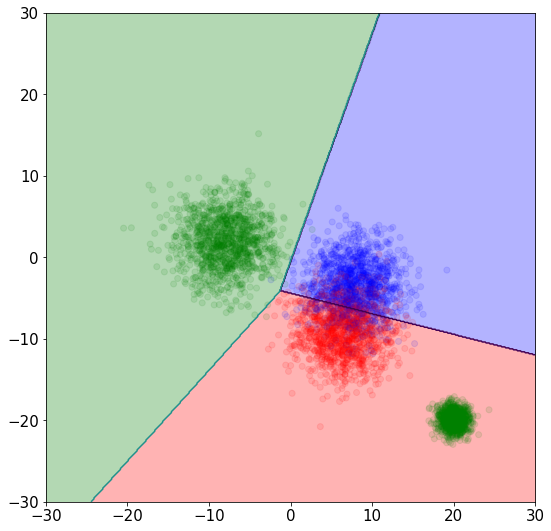

In [10]:
def plot_classifier(model, X, y, point = None):
    plt.figure(figsize=(10,10))
    plt.rcParams.update({'font.size': 15})
    N_points = 500
    xx,yy = np.meshgrid(np.linspace(-30,30,N_points),np.linspace(-30,30,N_points))
    viz=np.c_[xx.ravel(),yy.ravel()]
    z = np.argmax(model.predict(viz),axis=1)

    prd_colors = {
        0: 'b',
        1: 'r',
        2: 'g'
    }

    prd_color = [prd_colors[i] for i in y]
    cmap = mpl.colors.ListedColormap(prd_colors.values())

    plt.scatter(X[:, 0], X[:, 1], c=prd_color,  alpha=0.1)
    plt.gca().set_xlim([-30.,30.])
    plt.gca().set_ylim([-30.,30.])
    plt.imshow(z.reshape((N_points,N_points)), interpolation='bilinear', origin='lower', extent=(-30,30,-30,30),alpha=0.3, vmin=0, vmax=2, cmap=cmap)
    plt.contour(xx,yy,z.reshape((N_points,N_points)),[0,1,2])
    if point is not None:
      plt.plot(point[0], point[1], 'y*', markersize=30)
    plt.gcf().set_size_inches((9,9))

    plt.show()

plot_classifier(fake_model, X_test, y_test)

## Learning to identify OOD points
The main idea is to include in the training of the uncertainty a component that learns how to identify OOD points. The training will consist on adding the each batch a set of randomly generated points from a uniform distribution. These points will be annotated with an additional label indicating that the point does not belong to the distribution of the training data. The loss will include an additional term that depend on the new label d:
 $$loss = d(current\_loss) + (1-d)||beta||^{2}$$

First we generate random uniforms out of the original distribution in a square.
We also add a second term to the label telling whether the point belongs to the original distribution or not. We create a modified version of the original labels too.

In [11]:
from math import pi, cos, sin
import random

NUMBER_OOD_SAMPLES = 1000

def generate_random_points_uniform(num_samples, window):
    return np.random.uniform((-window,window),(window,-window),(num_samples, 2))

def generate_random_points_donut():
    def generate_random_point(h, k, r):
        theta = random.random() * 2 * pi
        return h + cos(theta) * r, k + sin(theta) * r
    random_points = []
    for i in range(NUMBER_OOD_SAMPLES):
        radius = random.uniform(20, 70)
        point = generate_random_point(-10, 7.5, radius)
    random_points.append(point)
    return np.array(random_points)

random_points = generate_random_points_uniform(NUMBER_OOD_SAMPLES, 20)
X_val_ood = np.concatenate((X_val, random_points))
y_val_ood = np.concatenate((np.insert(to_categorical(y_val,num_classes),3, 1, axis=-1), np.array([[1/num_classes,1/num_classes,1/num_classes,0]]*NUMBER_OOD_SAMPLES)))
fake_y_pred_val_ood = fake_model.predict(X_val_ood)

val_indexes = np.random.permutation(X_val_ood.shape[0])
X_val_ood = X_val_ood[val_indexes]
y_val_ood = y_val_ood[val_indexes]
fake_y_pred_val_ood = fake_y_pred_val_ood[val_indexes]

/Users/n955171/miniconda3/envs/uncertanty_modeller_env/lib/python3.6/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


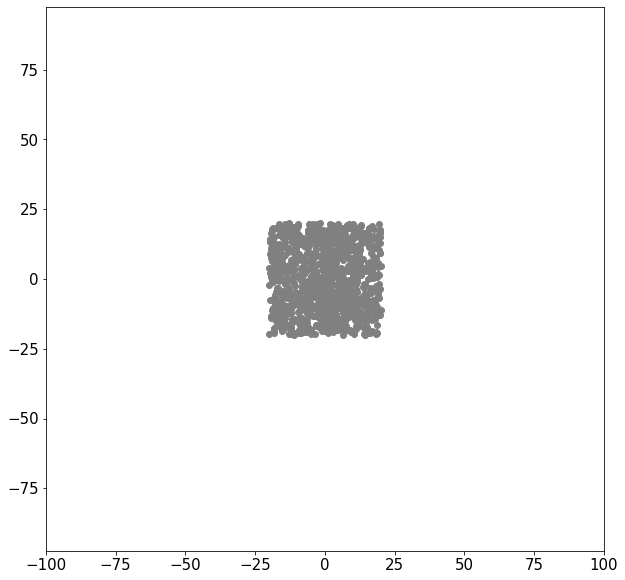

In [12]:
#ood_preds = K.get_session().run(ood_dirichlet_wrapper.predict_entropy(random_points, fake_model.predict(random_points)))
plt.figure(figsize=(10,10))
#plt.scatter(*zip(*random_points), c=ood_preds)
plt.gca().set_xlim([-100.,100.])
plt.gca().set_ylim([-100.,100.])
plt.scatter(*zip(*random_points), c='gray')
# plt.grid(color='k', linestyle=':', linewidth=1)
plt.axes().set_aspect('equal', 'datalim')

plt.show()

We define a new version of the DirichletWrapper that includes the new loss term.

In [27]:
from tensorflow.keras.layers import Dense, Input, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_accuracy
import tensorflow as tf
import tensorflow_probability as tfp
import math

class UncertaintyOODWrapper(object):
    def __init__(self, lambda_reg, num_samples, 
               learning_rate=1e-3, num_hidden_units=20):
        self.lambda_reg = lambda_reg
        self.epsilon = 1e-10
        self.num_samples = num_samples
        self.learning_rate = learning_rate
        self.num_hidden_units = num_hidden_units

    def kullback_leibler_divergence(self, y_true, y_pred):
        y_true = K.clip(y_true, K.epsilon(), 1)
        y_pred = K.clip(y_pred, K.epsilon(), 1)
        return K.sum(y_true * K.log(y_true / y_pred), axis=-1)

    def dirichlet_aleatoric_cross_entropy(self, y_true, y_pred):
        mu_probs = y_pred[:,:self.num_classes]
        logits_sigma = y_pred[:,self.num_classes:]
        beta = logits_sigma
        alpha = mu_probs * beta
        dirichlet = tfp.distributions.Dirichlet(alpha)
        z = dirichlet.sample(sample_shape=self.num_samples)
        e_probs = tf.reduce_mean(z, axis=0)
        log_probs = tf.log(e_probs+self.epsilon)
        cross_entropy = -(tf.reduce_sum(y_true[:,:self.num_classes] * log_probs, axis=-1))
        aleatoric_loss = cross_entropy + self.lambda_reg * tf.reduce_sum(beta, axis=-1)
        neg_entropy = tf.reduce_sum(e_probs * log_probs, axis=-1)
        # return y_true[:,self.num_classes:] * aleatoric_loss + (1 - y_true[:,self.num_classes:]) * tf.reduce_sum(logits_sigma, axis=-1)
        return y_true[:,self.num_classes:] * aleatoric_loss + (1 - y_true[:,self.num_classes:]) * self.kullback_leibler_divergence(y_true[:,:self.num_classes], e_probs)
  
    # metric that outputs the max/min value for the beta
    def max_beta(self, y_true, y_pred, **args):
        logits_psi = y_pred[:, self.num_classes:]
        return tf.reduce_max(logits_psi)

    def min_beta(self, y_true, y_pred, **args):
        logits_psi = y_pred[:, self.num_classes:]
        return tf.reduce_min(logits_psi)

    # metric that outputs the accuracy when only considering the logits_mu.
    # this accuracy should be the same that was obtained with the fake classifier
    # in its best epoch.
    #def mu_accuracy(self):
    #  num_classes = self.num_classes
    def mu_accuracy(self, y_true, y_pred, **args):
        logits_phi = y_pred[:, :self.num_classes]
        labels_phi = y_true[:, :self.num_classes]
        return categorical_accuracy(labels_phi, logits_phi)
      #  return get_mu_accuracy

    def create_model(self, input_shape):
        model_input = Input(shape=(input_shape,))
        logits_sigma = Dense(self.num_hidden_units, activation='relu')(model_input)
        logits_sigma = Dense(self.num_hidden_units,activation='relu')(logits_sigma)
        logits_sigma = Dense(self.num_hidden_units,activation='relu')(logits_sigma)
        logits_sigma = Dense(self.num_hidden_units,activation='relu')(logits_sigma)
        logits_sigma = Dense(1, activation='sigmoid')(logits_sigma)
        probs_mu = Input(shape=(self.num_classes,))
        output = concatenate([probs_mu, logits_sigma])

        model = Model(inputs=[model_input, probs_mu], outputs=output)
        model.compile(loss=self.dirichlet_aleatoric_cross_entropy,
                      optimizer=Adam(lr=self.learning_rate),
                      metrics=[self.min_beta, self.max_beta])
        return model
  
    def train_model(self, X, y, pred_y, batch_size=256, epochs=50):
        self.num_classes = pred_y.shape[1]
        input_shape = X.shape[1]
        self.model = self.create_model(input_shape)
        early = EarlyStopping(monitor='min_beta', mode='min', patience=100)
        callbacks_list = [early]  
        self.training_history = self.model.fit([X, pred_y],
                                 y,
                                 batch_size=batch_size,
                                 epochs=epochs,
                                 shuffle=True,
                                 verbose=1,
                                 validation_split=0.2,
                                 callbacks=callbacks_list)
    
    def predict_entropy(self, X, pred_y):
        y_pred = self.model.predict([X, pred_y])
        logits_mu = y_pred[:,:self.num_classes]
        mu_probs = tf.nn.softmax(logits_mu, axis=-1)
        logits_sigma = y_pred[:,self.num_classes:]
        beta = logits_sigma
        alpha = mu_probs * logits_sigma
        dirichlet = tfp.distributions.Dirichlet(alpha)
        z = dirichlet.sample(sample_shape=self.num_samples)
        e_probs = tf.reduce_mean(z, axis=0)
        log_probs = tf.log(e_probs+self.epsilon)
        entropy = tf.reduce_sum(-e_probs*log_probs, axis=-1)
        return entropy

    def voting(self, X, pred_y):
        y_pred = self.model.predict([X, pred_y])
        mu_probs = y_pred[:,:self.num_classes]
        logits_sigma = y_pred[:,self.num_classes:]
        beta = logits_sigma
        alpha = mu_probs * logits_sigma
        dirichlet = tfp.distributions.Dirichlet(alpha)
        z = dirichlet.sample(sample_shape=self.num_samples)
        z = tf.reshape(z, (lambda shape: (self.num_samples, shape[0], shape[1]))(tf.shape(mu_probs)))
        sampled_output = tf.argmax(z, axis=-1, output_type=tf.int32)
        sampled_output = tf.reshape(sampled_output, 
                                    (lambda shape: (self.num_samples, -1))(tf.shape(sampled_output)))
        sampled_output = tf.one_hot(sampled_output, axis=-1, depth=self.num_classes)
        sampled_output = tf.reduce_sum(sampled_output, axis=0)
        winner_classes = tf.argmax(sampled_output, axis=1)
        winner_classes = tf.one_hot(winner_classes, axis=-1, depth=self.num_classes)
        sampled_output = tf.reduce_sum(sampled_output * winner_classes, axis=-1)
        return 1-sampled_output/self.num_samples

In [28]:
from time import time
start_time = time()
ood_dirichlet_wrapper = UncertaintyOODWrapper(1e-1, 1000, learning_rate=1e-2, num_hidden_units=10)
ood_dirichlet_wrapper.train_model(X_val_ood, y_val_ood, fake_y_pred_val_ood,
                             epochs=50, batch_size=256)
"Done in %0.3fs" % (time() - start_time)

Train on 6720 samples, validate on 1680 samples
Epoch 1/50
6720/6720 [==============================] - 1s 185us/sample - loss: 0.8314 - min_beta: 8.3307e-05 - max_beta: 0.4726 - val_loss: 0.5910 - val_min_beta: 5.3346e-06 - val_max_beta: 0.2656
Epoch 2/50
6720/6720 [==============================] - 1s 153us/sample - loss: 0.5614 - min_beta: 1.3339e-05 - max_beta: 0.2649 - val_loss: 0.5410 - val_min_beta: 1.3168e-05 - val_max_beta: 0.2429
Epoch 3/50
6720/6720 [==============================] - 1s 153us/sample - loss: 0.5534 - min_beta: 5.0576e-06 - max_beta: 0.2496 - val_loss: 0.5465 - val_min_beta: 2.0223e-06 - val_max_beta: 0.2366
Epoch 4/50
6720/6720 [==============================] - 1s 160us/sample - loss: 0.5438 - min_beta: 4.5382e-05 - max_beta: 0.2382 - val_loss: 0.5407 - val_min_beta: 1.8490e-05 - val_max_beta: 0.2229
Epoch 5/50
6720/6720 [==============================] - 1s 149us/sample - loss: 0.5377 - min_beta: 3.0954e-05 - max_beta: 0.2058 - val_loss: 0.5358 - val_min_be

Epoch 42/50
6720/6720 [==============================] - 1s 143us/sample - loss: 0.5036 - min_beta: 1.4270e-05 - max_beta: 0.0661 - val_loss: 0.4980 - val_min_beta: 9.9880e-06 - val_max_beta: 0.0602
Epoch 43/50
6720/6720 [==============================] - 1s 144us/sample - loss: 0.5020 - min_beta: 1.6271e-05 - max_beta: 0.0631 - val_loss: 0.5003 - val_min_beta: 8.6640e-06 - val_max_beta: 0.0734
Epoch 44/50
6720/6720 [==============================] - 1s 147us/sample - loss: 0.5030 - min_beta: 6.8612e-06 - max_beta: 0.0632 - val_loss: 0.5027 - val_min_beta: 8.5320e-06 - val_max_beta: 0.0518
Epoch 45/50
6720/6720 [==============================] - 1s 149us/sample - loss: 0.5020 - min_beta: 1.0231e-05 - max_beta: 0.0651 - val_loss: 0.5035 - val_min_beta: 7.9232e-06 - val_max_beta: 0.0663
Epoch 46/50
6720/6720 [==============================] - 1s 151us/sample - loss: 0.5014 - min_beta: 9.0930e-06 - max_beta: 0.0647 - val_loss: 0.4973 - val_min_beta: 1.8375e-05 - val_max_beta: 0.0650
Epoch

'Done in 51.070s'

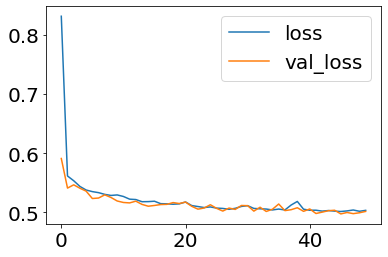

In [30]:
plt.plot(ood_dirichlet_wrapper.training_history.history['loss'], label='loss')
plt.plot(ood_dirichlet_wrapper.training_history.history['val_loss'], label='val_loss')
plt.legend()
# plt.xlim(10)
#plt.ylim(0.2,0.4)

In [31]:
dirichlet_ood_pred_entropy = K.get_session().run(ood_dirichlet_wrapper.predict_entropy(X_test, fake_y_pred_test))
random_test = generate_random_points_uniform(NUMBER_OOD_SAMPLES, 100)
random_test_preds = fake_model.predict(random_test)
random_dirichlet_ood_pred_entropy = K.get_session().run(ood_dirichlet_wrapper.predict_entropy(random_test, random_test_preds))

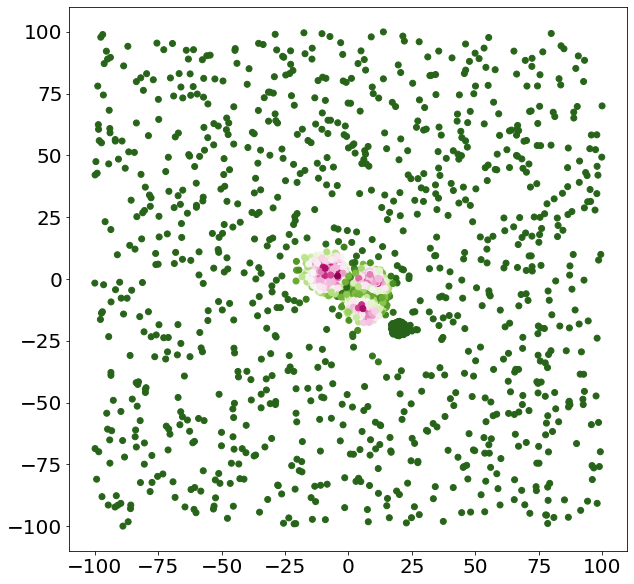

In [32]:
plt.figure(figsize=(10,10))
color = dirichlet_ood_pred_entropy
pa = plt.scatter(X_test[:,0],
         X_test[:,1], 
                 c=color, cmap='PiYG')

color = random_dirichlet_ood_pred_entropy
pd = plt.scatter(random_test[:,0],
         random_test[:,1], 
                 c=color, cmap='PiYG')

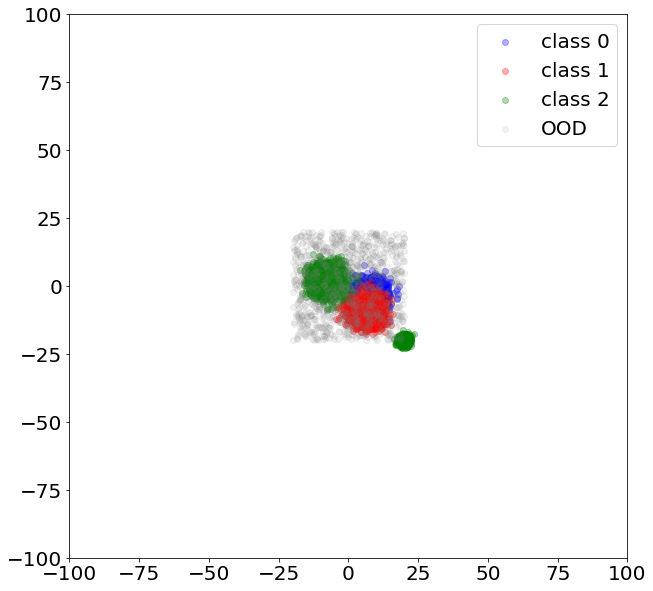

In [33]:
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(10,10))
plt.gca().set_xlim([-100.,100.])
plt.gca().set_ylim([-100.,100.])
plt.scatter(X_val_ood[:,0][y_val_ood[:,0]==1], X_val_ood[:,1][y_val_ood[:,0]==1], label='class 0', c='b',  alpha=0.3)
plt.scatter(X_val_ood[:,0][y_val_ood[:,1]==1], X_val_ood[:,1][y_val_ood[:,1]==1], label='class 1', c='r',  alpha=0.3)
plt.scatter(X_val_ood[:,0][y_val_ood[:,2]==1], X_val_ood[:,1][y_val_ood[:,2]==1], label='class 2', c='g',  alpha=0.3)
plt.scatter(X_val_ood[:,0][y_val_ood[:,3]==0], X_val_ood[:,1][y_val_ood[:,3]==0], label='OOD', c='gray',  alpha=0.1)
plt.legend()

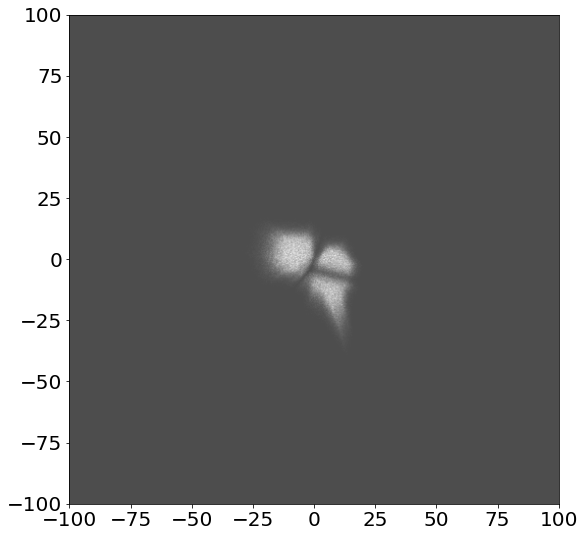

In [34]:
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(10,10))
plt.gca().set_xlim([-100.,100.])
plt.gca().set_ylim([-100.,100.])
N_points = 500
xx,yy = np.meshgrid(np.linspace(-100,100,N_points),np.linspace(-100,100,N_points))
viz=np.c_[xx.ravel(),yy.ravel()]
viz_preds = fake_model.predict(viz)
viz_dirichlet_ood_pred_entropy = K.get_session().run(ood_dirichlet_wrapper.predict_entropy(viz, viz_preds))
plt.imshow(viz_dirichlet_ood_pred_entropy.reshape((N_points,N_points)), interpolation='bilinear', origin='lower', extent=(-100,100,-100,100),alpha=0.7, vmin=viz_dirichlet_ood_pred_entropy.min(), vmax=viz_dirichlet_ood_pred_entropy.max(), cmap='binary')
#plt.contour(xx,yy,viz_dirichlet_ood_pred_entropy.reshape((N_points,N_points)),[0,1])
plt.gcf().set_size_inches((9,9))

plt.show()